In [1]:
!git clone https://github.com/facebookresearch/dinov3.git /kaggle/working/dinov3

Cloning into '/kaggle/working/dinov3'...
remote: Enumerating objects: 276, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 276 (delta 29), reused 11 (delta 11), pack-reused 222 (from 2)
Receiving objects: 100% (276/276), 9.80 MiB | 33.91 MiB/s, done.
Resolving deltas: 100% (60/60), done.


In [2]:
!pip install timm einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [3]:
import os 
from tqdm import tqdm
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
from sklearn.model_selection import train_test_split
from torchmetrics.classification import F1Score, Accuracy
from transformers import get_scheduler
from collections import Counter

In [4]:
os.path.exists('/kaggle/working/dinov3/hubconf.py')

True

In [5]:
leaves_path = "/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset"
plants_path = "/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal plant dataset"

In [6]:
leaves = os.listdir(leaves_path)
plants = os.listdir(plants_path)

In [7]:
leaves_labels = [f'leaf_{l}' for l in leaves]
plants_labels = [f'plant_{p}' for p in plants]
all_labels = leaves_labels + plants_labels
len(all_labels)

120

In [8]:
label2id = {label: idx for idx, label in enumerate(all_labels)}
id2label = {idx: label for idx, label in enumerate(all_labels)}

In [9]:
leaves_json = [
    {"img": os.path.join(leaves_path, folder, fname), "label": label2id[f"leaf_{folder}"]}
    for folder in os.listdir(leaves_path)
    for fname in os.listdir(os.path.join(leaves_path, folder))
    if '.jpg' in fname]
plants_json = [
    {"img": os.path.join(plants_path, folder, fname), "label": label2id[f"plant_{folder}"]}
    for folder in os.listdir(plants_path)
    for fname in os.listdir(os.path.join(plants_path, folder))
    if '.jpg' in fname]
all_json = leaves_json + plants_json
random.shuffle(all_json)

In [10]:
all_json[:10]

[{'img': '/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset/Doddpathre/176.jpg',
  'label': 68},
 {'img': '/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset/Papaya/20190919_173209.jpg',
  'label': 20},
 {'img': '/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset/Pumpkin/20190920_162153.jpg',
  'label': 16},
 {'img': '/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset/Coffee/P_20190924_101324.jpg',
  'label': 30},
 {'img': '/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset/Betel/1942.jpg',
  'label': 64},
 {'img': '/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset/Castor/508.jpg',
  'label': 19},
 {'img': '/kaggle/input/indian-medicinal-leaves-dat

In [11]:
transforms = A.Compose([
    A.Resize(224, 224), 
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])
aug_transforms = A.Compose([
    A.Resize(224, 224),  
    A.RandomResizedCrop((224, 224), scale=(0.8, 1.0), ratio=(0.9, 1.1), p=0.7), 
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
    A.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=20, val_shift_limit=15, p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.2),  
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [12]:
class CustomDataset(Dataset):
    def __init__(self, data, transforms):
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        img = np.array(Image.open(item["img"]).convert("RGB"))
        transformed = self.transforms(image=img)  
        return {"image": transformed["image"], "label": item["label"]}

dataset = CustomDataset(all_json,transforms)
aug_dataset = CustomDataset(all_json,aug_transforms)
final_dataset = ConcatDataset([dataset, aug_dataset])

In [13]:
labels = []
for ds in final_dataset.datasets: 
    if hasattr(ds, "data"):  
        labels.extend([item["label"] for item in ds.data])
    else:
        raise ValueError("Dataset does not expose .data with labels")
train_idx, test_idx = train_test_split(
    list(range(len(final_dataset))),
    test_size=0.1,  
    stratify=labels,
    random_state=42
)

In [14]:
all_labels_list = [item["label"] for item in all_json]
class_counts = Counter(all_labels_list)
print(class_counts)
num_classes = len(all_labels)

Counter({90: 187, 32: 177, 65: 176, 2: 168, 116: 168, 101: 165, 103: 164, 91: 160, 86: 153, 88: 152, 113: 151, 114: 150, 13: 149, 96: 146, 108: 146, 99: 146, 87: 146, 92: 146, 94: 146, 111: 146, 89: 146, 118: 146, 82: 146, 84: 146, 80: 146, 98: 146, 104: 146, 107: 146, 105: 146, 115: 146, 85: 146, 102: 146, 117: 146, 83: 146, 81: 146, 93: 146, 100: 146, 110: 146, 106: 146, 112: 146, 97: 146, 95: 146, 109: 146, 68: 142, 20: 135, 15: 135, 37: 134, 25: 132, 19: 129, 26: 128, 61: 123, 55: 118, 41: 118, 44: 118, 29: 115, 119: 115, 64: 114, 34: 114, 14: 113, 11: 110, 70: 106, 42: 104, 74: 103, 36: 99, 47: 97, 52: 93, 16: 92, 75: 92, 71: 91, 8: 90, 48: 89, 57: 89, 30: 83, 38: 82, 6: 82, 63: 81, 59: 81, 31: 81, 46: 80, 66: 80, 69: 79, 67: 79, 24: 76, 17: 76, 35: 76, 58: 76, 43: 75, 60: 75, 76: 74, 27: 73, 72: 73, 50: 73, 10: 72, 0: 69, 7: 69, 53: 69, 45: 68, 28: 67, 54: 67, 62: 67, 56: 67, 49: 66, 51: 66, 78: 63, 73: 62, 4: 62, 40: 61, 77: 61, 22: 59, 3: 56, 1: 51, 18: 49, 23: 48, 79: 47, 33: 

In [15]:
class_weights = [1.0 / class_counts[c] for c in range(num_classes)]
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights = class_weights / class_weights.sum() * num_classes
print(class_weights.shape)

torch.Size([120])


In [16]:
trainset = Subset(final_dataset, train_idx)
testset = Subset(final_dataset, test_idx)

print('Train Dataset:',len(trainset))
print('Test Dataset:',len(testset))

Train Dataset: 23121
Test Dataset: 2569


In [17]:
trainloader = DataLoader(trainset,batch_size=32,shuffle=True)
testloader = DataLoader(testset,batch_size=32,shuffle=False)

Labels: tensor([ 37,  86, 108, 112,  45,  95,  11,  42,  54,   0,  89,   1,  37, 100,
         50,  36,  54, 109,  69,  42, 115, 113, 100,  97,  59, 110,  32,  97,
          8,  41,   8,  75])


Text(0.5, 1.0, 'Label: 37')

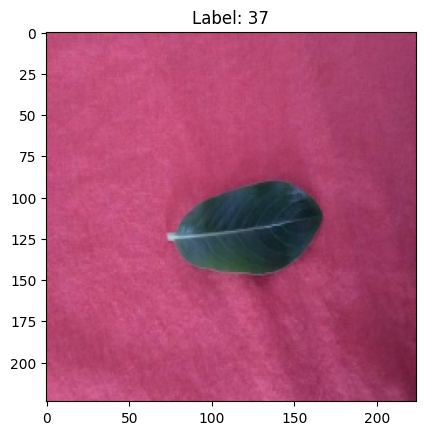

In [18]:
batch = next(iter(trainloader))
print("Labels:", batch["label"])

img = batch["image"][0].permute(1,2,0)  
plt.imshow((img * 0.229 + 0.485).clip(0,1)) 
plt.title(f"Label: {batch['label'][0]}")

In [19]:
REPO_DIR = '/kaggle/working/dinov3'   
CKPT_PATH = '/kaggle/input/dinov3/pytorch/default/1/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth'
feat_extract = torch.hub.load(REPO_DIR, 'dinov3_vitb16', source='local', weights=CKPT_PATH)

Downloading: "file:///kaggle/input/dinov3/pytorch/default/1/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth" to /root/.cache/torch/hub/checkpoints/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth
100%|██████████| 327M/327M [00:03<00:00, 94.7MB/s]


In [20]:
feat_extract.embed_dim

768

In [21]:
class DinoClassifier(nn.Module):
    def __init__(self, feat_extractor, cls_len, class_weights):
        super().__init__()
        self.feat_extractor = feat_extractor
        for param in self.feat_extractor.parameters():
            param.requires_grad = False
        self.cls_head = nn.Sequential(
            nn.Linear(self.feat_extractor.embed_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, cls_len)
        )
        self.loss = nn.CrossEntropyLoss(weight=class_weights)
        self.accuracy = Accuracy(task="multiclass", num_classes=cls_len)
        self.f1_score = F1Score(task="multiclass", num_classes=cls_len, average="macro")

    def forward(self, batch):
        x, y = batch['image'], batch['label']
        out = self.feat_extractor(x)  
        y_hat = self.cls_head(out)
        loss = self.loss(y_hat, y)
        acc, f1 = self.compute_metric(y_hat, y)
        return loss, acc, f1

    def compute_metric(self, y_hat, y):
        acc = self.accuracy(y_hat, y)
        f1 = self.f1_score(y_hat, y)
        return acc, f1

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [23]:
model = DinoClassifier(feat_extract,len(all_labels),class_weights).to(device)

In [24]:
model

DinoClassifier(
  (feat_extractor): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (rope_embed): RopePositionEmbedding()
    (blocks): ModuleList(
      (0-11): 12 x SelfAttentionBlock(
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): SelfAttention(
          (qkv): LinearKMaskedBias(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.

In [25]:
print(f"Total params: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Total params: 86,124,920
Trainable params: 455,288


In [26]:
num_epochs = 10
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4,weight_decay=5e-4)
num_training_steps = num_epochs * len(trainloader)
num_warmup_steps = int(0.1 * num_training_steps) 
scheduler = get_scheduler(
    name="cosine", 
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)
best_val_loss = float('inf')

In [27]:
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    train_acc = 0
    train_f1 = 0
    
    progress_bar = tqdm(trainloader, desc=f'Training {epoch+1}/{num_epochs}')
    for batch in progress_bar:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        optimizer.zero_grad()
        loss, acc, f1 = model(batch)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        train_acc += acc.item()
        train_f1 += f1.item()

        progress_bar.set_postfix({
            'loss': loss.item(),
            'acc': acc.item(),
            'f1': f1.item()
        })

    avg_train_loss = train_loss / len(trainloader)
    avg_train_acc = train_acc / len(trainloader)
    avg_train_f1 = train_f1 / len(trainloader)
    print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_acc:.4f}, F1: {avg_train_f1:.4f}')

    # Validation phase
    model.eval()
    val_loss = 0
    val_acc = 0
    val_f1 = 0
    
    with torch.no_grad():
        val_progress_bar = tqdm(testloader, desc=f'Validation {epoch+1}/{num_epochs}')
        for batch in val_progress_bar:
            batch = {k: v.to(device) for k, v in batch.items()}
            loss, acc, f1 = model(batch)
            val_loss += loss.item()
            val_acc += acc.item()
            val_f1 += f1.item()

    avg_val_loss = val_loss / len(testloader)
    avg_val_acc = val_acc / len(testloader)
    avg_val_f1 = val_f1 / len(testloader)
    print(f'Epoch {epoch+1}: Val Loss: {avg_val_loss:.4f}, Accuracy: {avg_val_acc:.4f}, F1: {avg_val_f1:.4f}')   

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_classifier.pth')
        print(f"Val Loss Improved to {avg_val_loss:.4f}. Model saved at epoch {epoch+1}")

Training 1/10: 100%|██████████| 723/723 [21:23<00:00,  1.77s/it, loss=1.93, acc=0.941, f1=0.875]


Epoch 1: Train Loss: 3.8218, Accuracy: 0.4232, F1: 0.3323


Validation 1/10: 100%|██████████| 81/81 [02:06<00:00,  1.57s/it]


Epoch 1: Val Loss: 1.8712, Accuracy: 0.8748, F1: 0.7851
Val Loss Improved to 1.8712. Model saved at epoch 1


Training 2/10: 100%|██████████| 723/723 [18:53<00:00,  1.57s/it, loss=0.509, acc=0.941, f1=0.882]


Epoch 2: Train Loss: 0.9654, Accuracy: 0.8976, F1: 0.8234


Validation 2/10: 100%|██████████| 81/81 [02:06<00:00,  1.57s/it]


Epoch 2: Val Loss: 0.4834, Accuracy: 0.9404, F1: 0.8897
Val Loss Improved to 0.4834. Model saved at epoch 2


Training 3/10: 100%|██████████| 723/723 [18:54<00:00,  1.57s/it, loss=0.577, acc=0.941, f1=0.882]


Epoch 3: Train Loss: 0.3645, Accuracy: 0.9431, F1: 0.8986


Validation 3/10: 100%|██████████| 81/81 [02:06<00:00,  1.56s/it]


Epoch 3: Val Loss: 0.2532, Accuracy: 0.9651, F1: 0.9337
Val Loss Improved to 0.2532. Model saved at epoch 3


Training 4/10: 100%|██████████| 723/723 [19:03<00:00,  1.58s/it, loss=0.3, acc=0.941, f1=0.882]


Epoch 4: Train Loss: 0.2185, Accuracy: 0.9629, F1: 0.9332


Validation 4/10: 100%|██████████| 81/81 [02:07<00:00,  1.57s/it]


Epoch 4: Val Loss: 0.1677, Accuracy: 0.9742, F1: 0.9503
Val Loss Improved to 0.1677. Model saved at epoch 4


Training 5/10: 100%|██████████| 723/723 [19:05<00:00,  1.58s/it, loss=0.0838, acc=1, f1=1]


Epoch 5: Train Loss: 0.1523, Accuracy: 0.9734, F1: 0.9516


Validation 5/10: 100%|██████████| 81/81 [02:07<00:00,  1.57s/it]


Epoch 5: Val Loss: 0.1275, Accuracy: 0.9776, F1: 0.9565
Val Loss Improved to 0.1275. Model saved at epoch 5


Training 6/10: 100%|██████████| 723/723 [18:55<00:00,  1.57s/it, loss=0.14, acc=0.941, f1=0.882]


Epoch 6: Train Loss: 0.1189, Accuracy: 0.9777, F1: 0.9591


Validation 6/10: 100%|██████████| 81/81 [02:07<00:00,  1.57s/it]


Epoch 6: Val Loss: 0.1089, Accuracy: 0.9815, F1: 0.9646
Val Loss Improved to 0.1089. Model saved at epoch 6


Training 7/10: 100%|██████████| 723/723 [18:57<00:00,  1.57s/it, loss=0.122, acc=0.941, f1=0.889]


Epoch 7: Train Loss: 0.1009, Accuracy: 0.9808, F1: 0.9641


Validation 7/10: 100%|██████████| 81/81 [02:06<00:00,  1.57s/it]


Epoch 7: Val Loss: 0.0896, Accuracy: 0.9823, F1: 0.9648
Val Loss Improved to 0.0896. Model saved at epoch 7


Training 8/10: 100%|██████████| 723/723 [19:03<00:00,  1.58s/it, loss=0.0949, acc=0.941, f1=0.882]


Epoch 8: Train Loss: 0.0914, Accuracy: 0.9816, F1: 0.9670


Validation 8/10: 100%|██████████| 81/81 [02:07<00:00,  1.58s/it]


Epoch 8: Val Loss: 0.0851, Accuracy: 0.9857, F1: 0.9728
Val Loss Improved to 0.0851. Model saved at epoch 8


Training 9/10: 100%|██████████| 723/723 [19:02<00:00,  1.58s/it, loss=0.0846, acc=1, f1=1]


Epoch 9: Train Loss: 0.0853, Accuracy: 0.9843, F1: 0.9712


Validation 9/10: 100%|██████████| 81/81 [02:06<00:00,  1.57s/it]


Epoch 9: Val Loss: 0.0804, Accuracy: 0.9865, F1: 0.9742
Val Loss Improved to 0.0804. Model saved at epoch 9


Training 10/10: 100%|██████████| 723/723 [19:04<00:00,  1.58s/it, loss=0.0498, acc=1, f1=1]


Epoch 10: Train Loss: 0.0828, Accuracy: 0.9843, F1: 0.9704


Validation 10/10: 100%|██████████| 81/81 [02:08<00:00,  1.59s/it]

Epoch 10: Val Loss: 0.0814, Accuracy: 0.9853, F1: 0.9721
